In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from cereeberus import ReebGraph, MapperGraph, Interleave, Assignment
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

import time
import random
from tqdm import tqdm
import itertools


# Optimizing on randomly generated mappers

In [47]:


def generate_custom_graph(n=10, p=0.5, max_height=3, seed=None):
    rng = random.Random(seed)
    
    while True:
        # Step 1: generate connected Erdős–Rényi graph
        G = nx.erdos_renyi_graph(n, p, seed=seed)
        if not nx.is_connected(G):
            continue
        
        # Step 2: assign integer heights
        heights = {node: rng.randint(0, max_height) for node in G.nodes()}
        
        # enforce at least one node at 0 and one at max_height
        heights[rng.choice(list(G.nodes()))] = 0
        heights[rng.choice(list(G.nodes()))] = max_height
        
        nx.set_node_attributes(G, heights, "height")
        
        # Step 3: remove forbidden edges
        to_remove = [(u, v) for u, v in G.edges() if heights[u] == heights[v]]
        G.remove_edges_from(to_remove)
        
        # Step 4: check connectivity
        if nx.is_connected(G):
            return G, heights
        # otherwise retry



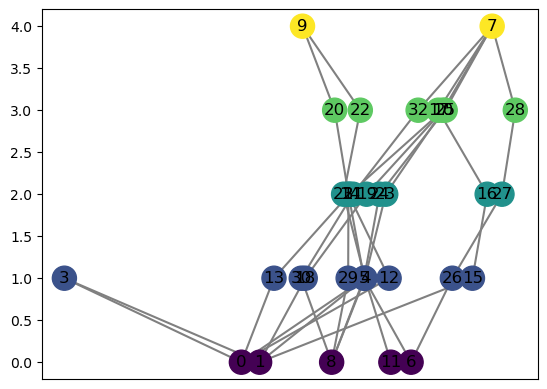

In [33]:
# make it a MapperGraph 

rG1 = ReebGraph(G1, f = heights1)
mG1 = rG1.to_mapper()
mG1.draw()


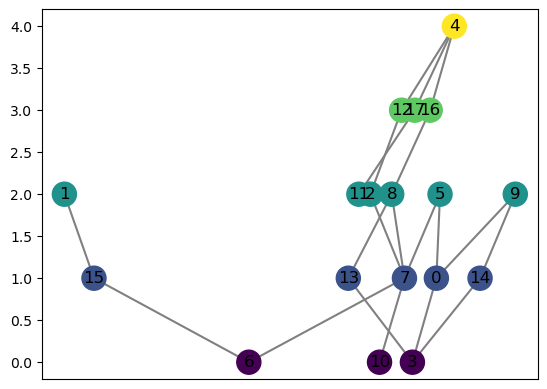

In [34]:

rG2 = ReebGraph(G2, f = heights2)
mG2 = rG2.to_mapper()
mG2.draw()

In [29]:
myInt = Interleave(mG1, mG2)
myInt.fit_with_D()

KeyboardInterrupt: 

In [36]:
print(f"Graph 1: {mG1.number_of_nodes()} nodes, {mG1.number_of_edges()} edges")
print(f"Graph 2: {mG2.number_of_nodes()} nodes, {mG2.number_of_edges()} edges")

Graph 1: 33 nodes, 42 edges
Graph 2: 18 nodes, 20 edges


In [38]:
myInt = Interleave(mG1, mG2)
myInt.fit()

2

### NOTE: optimization without the distance matrix runs much faster


# More experiments with random graphs

In [81]:


def make_subdivided_graph(level_sizes, edge_prob=0.5, seed=None):
    rng = random.Random(seed)
    G = nx.Graph()
    node_id = 0
    heights = {}

    # create nodes at each height
    level_nodes = []
    for h, size in enumerate(level_sizes):
        nodes = []
        for _ in range(size):
            G.add_node(node_id, height=h)
            heights[node_id] = h
            nodes.append(node_id)
            node_id += 1
        level_nodes.append(nodes)

    # add edges between consecutive levels
    for h in range(len(level_sizes) - 1):
        nodes_h = level_nodes[h]
        nodes_h1 = level_nodes[h+1]

        # ensure connectivity bottom→top
        for u in nodes_h:
            v = rng.choice(nodes_h1)
            G.add_edge(u, v)

        # ensure connectivity top→bottom
        for v in nodes_h1:
            u = rng.choice(nodes_h)
            G.add_edge(u, v)

        # add extra random edges
        for u in nodes_h:
            for v in nodes_h1:
                if not G.has_edge(u, v) and rng.random() < edge_prob:
                    G.add_edge(u, v)

    return G, heights

In [117]:
graphs = {}

# experimental factors
node_levels = [4, 6, 8]
edge_probs = [0.3, 0.5, 0.7]
height_level = 5
replications = 3

for n in node_levels:
    for p in edge_probs:
        for rep in range(replications):
            seed = n * 100 + int(p * 10) * 10 + rep
            g, h = make_subdivided_graph(
                [n for _ in range(height_level)], edge_prob=p, seed=seed)
            rg = ReebGraph(g, f=h)
            mg = rg.to_mapper()
            key = f"n{n}_p{int(p*10)}_r{rep}"
            graphs[key] = mg


In [118]:
len(graphs)

27

In [119]:
# print how many nodes and edges each graph has
for k in graphs.keys():
    g = graphs[k]
    print(f"{k}: {g.number_of_nodes()} nodes, {g.number_of_edges()} edges")

n4_p3_r0: 20 nodes, 41 edges
n4_p3_r1: 20 nodes, 37 edges
n4_p3_r2: 20 nodes, 40 edges
n4_p5_r0: 20 nodes, 41 edges
n4_p5_r1: 20 nodes, 48 edges
n4_p5_r2: 20 nodes, 40 edges
n4_p7_r0: 20 nodes, 53 edges
n4_p7_r1: 20 nodes, 56 edges
n4_p7_r2: 20 nodes, 54 edges
n6_p3_r0: 30 nodes, 70 edges
n6_p3_r1: 30 nodes, 68 edges
n6_p3_r2: 30 nodes, 75 edges
n6_p5_r0: 30 nodes, 99 edges
n6_p5_r1: 30 nodes, 85 edges
n6_p5_r2: 30 nodes, 106 edges
n6_p7_r0: 30 nodes, 121 edges
n6_p7_r1: 30 nodes, 114 edges
n6_p7_r2: 30 nodes, 113 edges
n8_p3_r0: 40 nodes, 118 edges
n8_p3_r1: 40 nodes, 115 edges
n8_p3_r2: 40 nodes, 115 edges
n8_p5_r0: 40 nodes, 156 edges
n8_p5_r1: 40 nodes, 159 edges
n8_p5_r2: 40 nodes, 161 edges
n8_p7_r0: 40 nodes, 196 edges
n8_p7_r1: 40 nodes, 203 edges
n8_p7_r2: 40 nodes, 208 edges


In [120]:
graphs.keys()

dict_keys(['n4_p3_r0', 'n4_p3_r1', 'n4_p3_r2', 'n4_p5_r0', 'n4_p5_r1', 'n4_p5_r2', 'n4_p7_r0', 'n4_p7_r1', 'n4_p7_r2', 'n6_p3_r0', 'n6_p3_r1', 'n6_p3_r2', 'n6_p5_r0', 'n6_p5_r1', 'n6_p5_r2', 'n6_p7_r0', 'n6_p7_r1', 'n6_p7_r2', 'n8_p3_r0', 'n8_p3_r1', 'n8_p3_r2', 'n8_p5_r0', 'n8_p5_r1', 'n8_p5_r2', 'n8_p7_r0', 'n8_p7_r1', 'n8_p7_r2'])

In [121]:
graph_names = list(graphs.keys())
dist_matrix = pd.DataFrame(index=graph_names, columns=graph_names)

pairs = [(i, j) for i in range(len(graph_names)) for j in range(i, len(graph_names))]

for i, j in tqdm(pairs, desc="Computing distances"):
    name1 = graph_names[i]
    name2 = graph_names[j]

    myInt = Interleave(graphs[name1], graphs[name2])
    # verbose=True can be kept if you want internal logs
    upper_bound = myInt.fit(verbose=False)  # suppress internal prints for speed

    dist_matrix.loc[name1, name2] = upper_bound
    dist_matrix.loc[name2, name1] = upper_bound  # symmetric

    # save after each pair
    dist_matrix.to_csv("dist_matrix_progress.csv")


Computing distances:   0%|          | 0/378 [00:00<?, ?it/s]

Computing distances:   2%|▏         | 9/378 [16:40<11:23:27, 111.13s/it]


KeyboardInterrupt: 

mg1 = 33, mg2 = 18, time = 10.5s

### NOTE: run a large scale experiment later    

# Trying out randomly generated large graphs

In [139]:
G1, heights1 = generate_custom_graph(n = 10, p = 0.4, max_height = 5, seed = 0)
G2, heights2 = generate_custom_graph(n = 10, p = 0.5, max_height = 5, seed = 8)


rg1 = ReebGraph(G1, f = heights1)
mg1 = rg1.to_mapper()


rg2 = ReebGraph(G2, f = heights2)
mg2 = rg2.to_mapper()



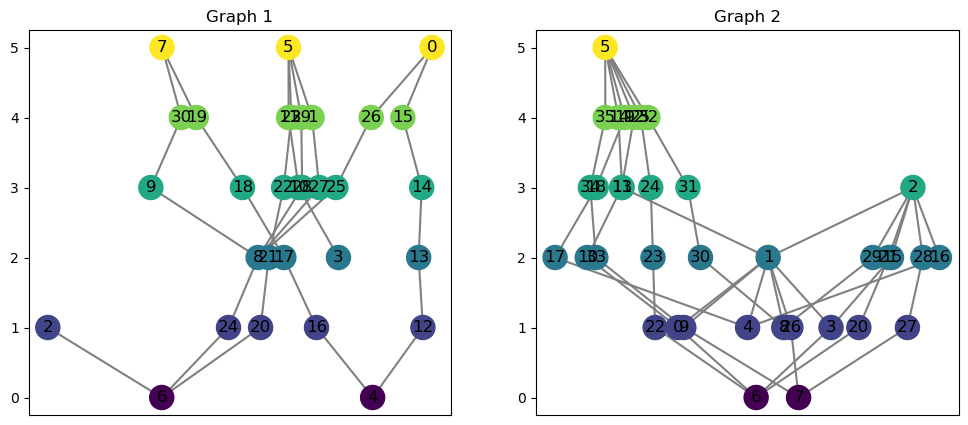

In [140]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
mg1.draw(with_labels=True)
plt.title("Graph 1")
plt.subplot(1, 2, 2)
mg2.draw(with_labels=True)
plt.title("Graph 2")
plt.show()  

In [141]:
print(f"Graph 1: {mg1.number_of_nodes()} nodes, {mg1.number_of_edges()} edges")
print(f"Graph 2: {mg2.number_of_nodes()} nodes, {mg2.number_of_edges()} edges")

Graph 1: 31 nodes, 33 edges
Graph 2: 36 nodes, 47 edges


In [142]:
myInt = Interleave(mg1, mg2)

In [143]:
myInt.fit(verbose=True)


-
Trying n = 0...
n = 0, status = None

-
Trying n = 1...
n = 1, status = None

-
Trying n = 2...
n = 2, status = None

-
Trying n = 4...
n = 4, status = 1

-
Trying n = 3...
n = 3, status = 1

-
Trying n = 2...
n = 2, status = None


3

reached graph generation
reached graph 3 to mapper
reached graph 4 to mapper


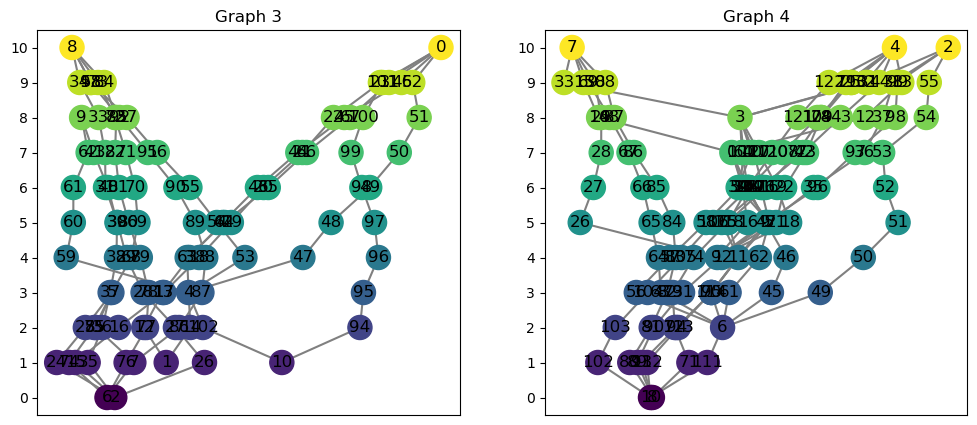

In [48]:
G3, heights3 = generate_custom_graph(n = 12, p = 0.3, max_height = 10, seed = 42)
G4, heights4 = generate_custom_graph(n = 12, p = 0.5, max_height = 10, seed = 12)

print ("reached graph generation")
rg3 = ReebGraph(G3, f = heights3)
mg3 = rg3.to_mapper()

print ("reached graph 3 to mapper")

rg4 = ReebGraph(G4, f = heights4)
mg4 = rg4.to_mapper()

print ("reached graph 4 to mapper")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
mg3.draw(with_labels=True)  
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
plt.title("Graph 3")
plt.subplot(1, 2, 2)
mg4.draw(with_labels=True)
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
plt.title("Graph 4")
plt.show()



In [49]:
print(f"Graph 3: {mg3.number_of_nodes()} nodes, {mg3.number_of_edges()} edges")
print(f"Graph 4: {mg4.number_of_nodes()} nodes, {mg4.number_of_edges()} edges")

Graph 3: 103 nodes, 111 edges
Graph 4: 123 nodes, 145 edges


In [31]:
myInt = Interleave(mg3, mg4)
myInt.fit(verbose=True)


-
Trying n = 0...
n = 0, status = None

-
Trying n = 1...
n = 1, status = None

-
Trying n = 2...
n = 2, status = None

-
Trying n = 4...
n = 4, status = 1

-
Trying n = 3...
n = 3, status = None

-
Trying n = 4...
n = 4, status = 1


4

| Graph 1 Node Size | Graph 2 Node Size | Time Taken (s) |
|-------------------|-------------------|----------------|
|          33         |            18      |       10.6         |
|          31         |            36       |        24.8        |
|           99        |            107       |         426       |
|            33       |              60     |          33.8      |
|         80       |             67     |          105      |

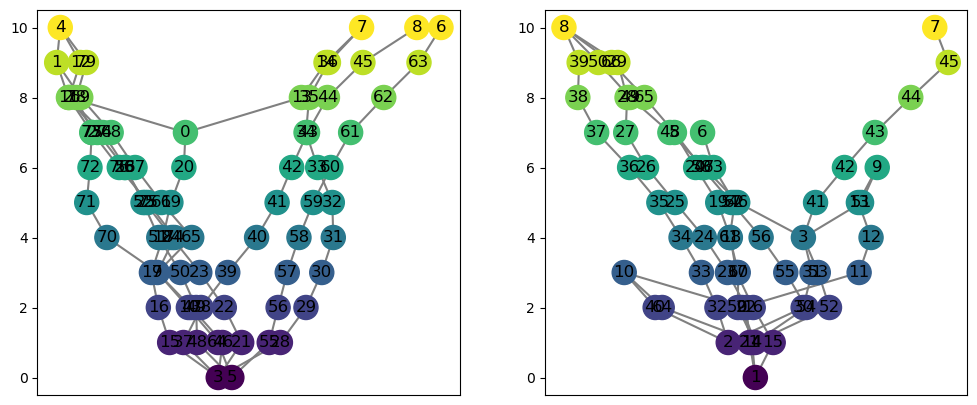

In [58]:
G5, heights5 = generate_custom_graph(n = 11, p = 0.3, max_height = 10, seed = -40)
G6, heights6 = generate_custom_graph(n = 11, p = 0.3, max_height = 10, seed = 1)

rg5 = ReebGraph(G5, f = heights5)
mg5 = rg5.to_mapper()   
rg6 = ReebGraph(G6, f = heights6)
mg6 = rg6.to_mapper()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
mg5.draw(with_labels=True)
plt.subplot(1, 2, 2)
mg6.draw(with_labels=True)
plt.show()

In [59]:
print(f"Graph 5: {mg5.number_of_nodes()} nodes, {mg5.number_of_edges()} edges")
print(f"Graph 6: {mg6.number_of_nodes()} nodes, {mg6.number_of_edges()} edges")

Graph 5: 80 nodes, 85 edges
Graph 6: 67 nodes, 73 edges


In [60]:
myInt = Interleave(mg5, mg6)
myInt.fit(verbose=True)


-
Trying n = 0...
n = 0, status = None

-
Trying n = 1...
n = 1, status = None

-
Trying n = 2...
n = 2, status = None

-
Trying n = 4...
n = 4, status = 1

-
Trying n = 3...
n = 3, status = None

-
Trying n = 4...
n = 4, status = 1


4

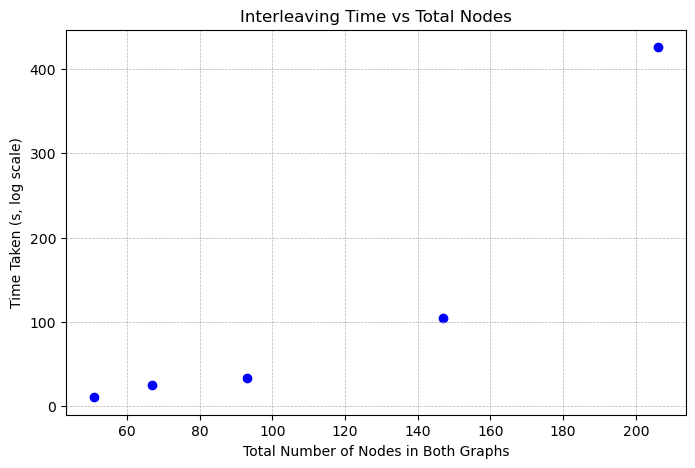

In [ ]:
Total_nodes = [33+18, 31+36, 99+107, 33+60, 80+67]
Times = [10.6, 24.8, 426, 33.8, 105]

plt.figure(figsize=(8, 5))
plt.scatter(Total_nodes, Times, color='blue')
# plt.yscale('log')
plt.xlabel('Total Number of Nodes in Both Graphs')
plt.ylabel('Time Taken (s, log scale)')
plt.title('Interleaving Time vs Total Nodes')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()